# initial analysis of runtimes

In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import display_html

pd.options.display.max_rows = 400
from metadata_utils import get_metadata, get_tuned_alg_perf, process_metafeatures, compute_feature_corrs

In [2]:
dataset_version = ""

metadataset_df, metafeatures_df = get_metadata(dataset_version)


In [3]:
# get the number of instances for each dataset, we will use these later
num_instances = metafeatures_df.loc[:, ["dataset_name", "f__pymfe.general.nr_inst"]] #.set_index('dataset_name')["f__pymfe.general.nr_inst"].to_dict() # .reset_index().to_dict()
num_instances.columns = ["dataset_fold_id", "num_inst"]

In [4]:
# keep only binary and classification datasets
print(metadataset_df["target_type"].value_counts())

metadataset_df = metadataset_df.loc[metadataset_df["target_type"].isin(["binary", "classification"]), :]

metadataset_df = metadataset_df.merge(num_instances, on="dataset_fold_id", how="left")

binary            565310
classification    417230
regression        102790
Name: target_type, dtype: int64


In [5]:
# check that all dataset-alg pairs have results for all 10 folds
print(metadataset_df.groupby(["alg_name", "dataset_name"]).agg({"dataset_fold_id": lambda x: len(set(x))}))

                                                                dataset_fold_id
alg_name    dataset_name                                                       
CatBoost    openml__APSFailure__168868                                       10
            openml__Amazon_employee_access__34539                            10
            openml__Australian__146818                                       10
            openml__Bioresponse__9910                                        10
            openml__Census-Income__168340                                    10
            openml__Click_prediction_small__190408                           10
            openml__Fashion-MNIST__146825                                    10
            openml__GesturePhaseSegmentationProcessed__14969                 10
            openml__Internet-Advertisements__167125                          10
            openml__JapaneseVowels__3510                                     10
            openml__LED-display-domain-7

## Analyze num. results per dataset and alg

In [6]:
# for each alg, for how many datasets are there results?
print(f"for each alg: number of datasets with results (out of {len(metadataset_df['dataset_name'].unique())})")
print(metadataset_df.groupby("alg_name")["dataset_name"].apply(lambda x: len(set(x))).sort_values())

print(f"for each dataset: number of algs with results (out of {len(metadataset_df['alg_name'].unique())})")
metadataset_df.groupby("dataset_name")["alg_name"].apply(lambda x: len(set(x))).sort_values()

for each alg: number of datasets with results (out of 176)
alg_name
TabPFNModel            63
NAM                    80
DeepFM                 90
SAINT                 106
TabTransformer        124
NODE                  138
rtdl_FTTransformer    139
SVM                   143
DANet                 147
VIME                  163
STG                   164
CatBoost              165
LightGBM              165
KNN                   167
LinearModel           168
TabNet                168
RandomForest          173
XGBoost               174
rtdl_ResNet           174
MLP                   175
DecisionTree          175
rtdl_MLP              176
Name: dataset_name, dtype: int64
for each dataset: number of algs with results (out of 22)


dataset_name
openml__poker-hand__9890                                   5
openml__covertype__7593                                    7
openml__albert__189356                                     8
openml__Devnagari-Script__167121                           8
openml__helena__168329                                     9
openml__CIFAR_10__167124                                  10
openml__walking-activity__9945                            11
openml__airlines__189354                                  11
openml__Fashion-MNIST__146825                             11
openml__guillermo__168337                                 12
openml__riccardo__168338                                  12
openml__mnist_784__3573                                   12
openml__robert__168332                                    12
openml__Census-Income__168340                             12
openml__ldpa__9974                                        13
openml__higgs__146606                                     14
openml__ski

## Remove datasets with few results

In [7]:
print(f"for each dataset: number of algs with results")
alg_counts = metadataset_df.groupby("dataset_name")["alg_name"].agg(lambda x: len(set(x))).sort_values()
print(alg_counts)

for each dataset: number of algs with results
dataset_name
openml__poker-hand__9890                                   5
openml__covertype__7593                                    7
openml__albert__189356                                     8
openml__Devnagari-Script__167121                           8
openml__helena__168329                                     9
openml__CIFAR_10__167124                                  10
openml__walking-activity__9945                            11
openml__airlines__189354                                  11
openml__Fashion-MNIST__146825                             11
openml__guillermo__168337                                 12
openml__riccardo__168338                                  12
openml__mnist_784__3573                                   12
openml__robert__168332                                    12
openml__Census-Income__168340                             12
openml__ldpa__9974                                        13
openml__higgs__146606     

In [8]:
keep_datasets = list(alg_counts[alg_counts >= 10].index)
drop_datasets = alg_counts[alg_counts < 10]

print(f"dropping {len(drop_datasets)} datasets:")
print(drop_datasets)

dropping 5 datasets:
dataset_name
openml__poker-hand__9890            5
openml__covertype__7593             7
openml__albert__189356              8
openml__Devnagari-Script__167121    8
openml__helena__168329              9
Name: alg_name, dtype: int64


In [9]:
print("for each alg: number of datasets with results")
dataset_counts = metadataset_df.groupby("alg_name")["dataset_name"].agg(lambda x: len(set(x))).sort_values()
print(dataset_counts)

for each alg: number of datasets with results
alg_name
TabPFNModel            63
NAM                    80
DeepFM                 90
SAINT                 106
TabTransformer        124
NODE                  138
rtdl_FTTransformer    139
SVM                   143
DANet                 147
VIME                  163
STG                   164
CatBoost              165
LightGBM              165
KNN                   167
LinearModel           168
TabNet                168
RandomForest          173
XGBoost               174
rtdl_ResNet           174
MLP                   175
DecisionTree          175
rtdl_MLP              176
Name: dataset_name, dtype: int64


We will keep all algs, regardless of how many datasets they have results for.

In [10]:
metadataset_df = metadataset_df.loc[metadataset_df["dataset_name"].isin(keep_datasets), :]

print("after removing datasets: number of datasets with results")
dataset_counts = metadataset_df.groupby("alg_name")["dataset_name"].agg(lambda x: len(set(x))).sort_values()
print(dataset_counts)

after removing datasets: number of datasets with results
alg_name
TabPFNModel            63
NAM                    80
DeepFM                 90
SAINT                 106
TabTransformer        122
NODE                  138
rtdl_FTTransformer    139
SVM                   143
DANet                 147
VIME                  162
CatBoost              163
STG                   163
KNN                   164
LightGBM              164
TabNet                166
LinearModel           167
RandomForest          170
MLP                   170
rtdl_ResNet           170
XGBoost               171
DecisionTree          171
rtdl_MLP              171
Name: dataset_name, dtype: int64


# Calculate average runtime per samples, over all folds

- only include algs parameterized with default hparams
- also calculate normalized accuracy for comparing runtime with performance

In [11]:
# get only the default hparams for each dataset
default_rows = metadataset_df.loc[metadataset_df["hparam_source"] == "default"].copy()

In [12]:
default_rows.head()

,results_bucket_path,dataset_fold_id,dataset_name,target_type,alg_name,hparam_source,trial_number,alg_hparam_id,exp_name,time__train,...,Accuracy__test,F1__test,time__train-eval,MSE__train,R2__train,MSE__val,R2__val,MSE__test,R2__test,num_inst
0,results/openml__APSFailure__168868/CatBoost/gp...,openml__APSFailure__168868__fold_0,openml__APSFailure__168868,binary,CatBoost,default,0,CatBoost__seed_0__trial_0,gpu-expt-a_091822_065111_fdd9.zip,4.039096,...,0.993421,0.993421,0.185535,NaN,NaN,NaN,NaN,NaN,NaN,60800
30,results/openml__APSFailure__168868/DecisionTre...,openml__APSFailure__168868__fold_0,openml__APSFailure__168868,binary,DecisionTree,default,0,DecisionTree__seed_0__trial_0,cpu-expt_092722_193320_6805.zip,10.585861,...,0.989079,0.989079,0.116210,NaN,NaN,NaN,NaN,NaN,NaN,60800
60,results/openml__APSFailure__168868/DeepFM/algs...,openml__APSFailure__168868__fold_0,openml__APSFailure__168868,binary,DeepFM,default,0,DeepFM__seed_0__trial_0,algs-gpu-2-datasets-a_113022_042418_0797.zip,69.833221,...,0.981974,0.981974,1.259654,NaN,NaN,NaN,NaN,NaN,NaN,60800
90,results/openml__APSFailure__168868/KNN/cpu-exp...,openml__APSFailure__168868__fold_0,openml__APSFailure__168868,binary,KNN,default,0,KNN__seed_0__trial_0,cpu-expt_091822_200045_4107.zip,2.620563,...,0.986184,0.986184,507.107627,NaN,NaN,NaN,NaN,NaN,NaN,60800
97,results/openml__APSFailure__168868/LightGBM/cp...,openml__APSFailure__168868__fold_0,openml__APSFailure__168868,binary,LightGBM,default,0,LightGBM__seed_0__trial_0,cpu-expt_092822_041400_5f19.zip,15.418114,...,0.987500,0.987500,0.399369,NaN,NaN,NaN,NaN,NaN,NaN,60800


In [13]:
# calcualte the normalized accuracy for each fold, and rank algs

metric = "Accuracy"
time_col = "time__train"

test_metric_col = metric + "__test"
time_per_inst_col = "train_per_1000_inst"

default_rows.loc[:, time_per_inst_col] = 1000. * default_rows[time_col] / metadataset_df["num_inst"]

tuned_alg_perf = default_rows.copy()

result_col = test_metric_col

# keep these cols to merge
merge_cols = [
    "alg_name", 
    "dataset_fold_id", 
    "normalized_" + result_col,
    "normalized_" + time_col,
    f"{metric}_rank",
    f"{time_col}_rank",
    f"{time_per_inst_col}_rank",
    result_col + "_min",
    result_col + "_max",
    time_col + "_min",
    time_col + "_max"
]

fold_tuned_df = tuned_alg_perf.copy()


###### step 2...

agg_dict = {
    test_metric_col: ["median", "mean"],
    time_col: ["median", "mean"],
    time_per_inst_col: ["median", "mean"],
}

# aggregate over folds: take the mean & median performance over each fold
agg_tuned_alg_perf = tuned_alg_perf.groupby(["alg_name", "dataset_name"]).agg(agg_dict).reset_index()

# rename the multiindex cols
new_cols = []
for c in agg_tuned_alg_perf.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))

agg_tuned_alg_perf.columns = new_cols


# define the target metric column, we will use this value for all plots
result_col = test_metric_col + "_mean"
time_result_col = time_col + "_mean"
time_per_inst_col = time_per_inst_col + "_mean"



#### WITH tabpfn

df = agg_tuned_alg_perf.copy()

# keep only datasets where tabpfn has a result
tabpfn_datasets = df[df["alg_name"] == "TabPFNModel"]["dataset_name"].unique()
df = df.loc[df["dataset_name"].isin(tabpfn_datasets), :]

# for each dataset, find the min and max metrics over all tuned algs
overall_bounds = df.groupby("dataset_name").agg({result_col: ["min", "max"]}).reset_index()

# rename the multiindex cols
new_cols = []
for c in overall_bounds.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))
overall_bounds.columns = new_cols

df = df.merge(overall_bounds, on="dataset_name", how="left")

# add normalized metric
df.loc[:, "normalized_" + result_col] = (df[result_col] - df[result_col + "_min"]) / (df[result_col + "_max"] - df[result_col + "_min"])

# rank all algs for each dataset
ascending = False # if objective_type == "maximize" else True

df.loc[:, f"{metric}_rank"] = df.groupby(["dataset_name"])[result_col].rank(method="min", ascending=ascending).values
df.loc[:, f"{time_col}_rank"] = df.groupby(["dataset_name"])[time_result_col].rank(method="min", ascending=True).values
df.loc[:, f"{time_per_inst_col}_rank"] = df.groupby(["dataset_name"])[time_per_inst_col].rank(method="min", ascending=True).values

tabpfn_df = df.copy()


#### WITHOUT tabpfn

df = agg_tuned_alg_perf.loc[agg_tuned_alg_perf["alg_name"] != "TabPFNModel", :].copy()

# for each dataset, find the min and max metrics over all tuned algs
overall_bounds = df.groupby("dataset_name").agg({result_col: ["min", "max"]}).reset_index()

# rename the multiindex cols
new_cols = []
for c in overall_bounds.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))
overall_bounds.columns = new_cols

df = df.merge(overall_bounds, on="dataset_name", how="left")

# add normalized metric
df.loc[:, "normalized_" + result_col] = (df[result_col] - df[result_col + "_min"]) / (df[result_col + "_max"] - df[result_col + "_min"])

# rank all algs for each dataset
ascending = False # if objective_type == "maximize" else True

df.loc[:, f"{metric}_rank"] = df.groupby(["dataset_name"])[result_col].rank(method="min", ascending=ascending).values
df.loc[:, f"{time_col}_rank"] = df.groupby(["dataset_name"])[time_result_col].rank(method="min", ascending=True).values
df.loc[:, f"{time_per_inst_col}_rank"] = df.groupby(["dataset_name"])[time_per_inst_col].rank(method="min", ascending=True).values

no_tabpfn_df = df.copy()



In [14]:
no_tabpfn_df.head()

,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,train_per_1000_inst_median,train_per_1000_inst_mean,Accuracy__test_mean_min,Accuracy__test_mean_max,normalized_Accuracy__test_mean,Accuracy_rank,time__train_rank,train_per_1000_inst_mean_rank
0,CatBoost,openml__APSFailure__168868,0.993092,0.992618,2.803810,2.933755,0.046115,0.048253,0.981579,0.993947,0.892553,2.0,3.0,3.0
1,CatBoost,openml__Amazon_employee_access__34539,0.945979,0.946016,1.566044,1.703913,0.059737,0.064997,0.928927,0.952150,0.735871,2.0,5.0,5.0
2,CatBoost,openml__Australian__146818,0.862319,0.865217,1.209536,1.307000,2.191189,2.367753,0.601449,0.865217,1.000000,1.0,8.0,8.0
3,CatBoost,openml__Bioresponse__9910,0.786667,0.782994,2.447543,2.595033,0.815576,0.864788,0.727272,0.793123,0.846182,3.0,6.0,6.0
4,CatBoost,openml__Census-Income__168340,0.955996,0.956377,10.708546,273.795613,0.044725,1.143541,0.943238,0.957923,0.894729,3.0,7.0,7.0


In [15]:
# WITHOUT tabpfn

# create a table of runtime rankings, sorted by avg. rank
# also show mean time-per-1000-instances

metric = time_per_inst_col

# overall_ranks = non_tabpfn_agg_df_no_default.groupby("alg_name").agg(
overall_ranks = no_tabpfn_df.groupby("alg_name").agg(
    {
        f"{metric}_rank": ["min", "max", "mean", "count"],
        f"{metric}": "mean",
        # "Accuracy_rank": "mean",
    }
).reset_index().sort_values([(f"{metric}_rank", "mean")])

# format min/max rank columns to be ints

overall_ranks.loc[:, "count"] = overall_ranks.loc[:, (f"{metric}_rank", "count")].astype(int)
overall_ranks.drop(columns=(f"{metric}_rank", "count"), inplace=True)

# overall_ranks.loc[:, "alg_name"] = overall_ranks.loc[:, "alg_name"].apply(lambda x: "\rot{" + x + "}")
overall_ranks.loc[:, (f"{metric}_rank", "min")] = overall_ranks.loc[:, (f"{metric}_rank", "min")].astype(int)
overall_ranks.loc[:, (f"{metric}_rank", "max")] = overall_ranks.loc[:, (f"{metric}_rank", "max")].astype(int)

overall_ranks.loc[:, (f"{metric}_rank", "mean")] = overall_ranks.loc[:, (f"{metric}_rank", "mean")].round(2)
# overall_ranks.loc[:, ("Accuracy_rank", "mean")] = overall_ranks.loc[:, ("Accuracy_rank", "mean")].round(2)

# overall_ranks.loc[:, (f"normalized_{metric}", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}", "mean")].round(2)
overall_ranks.loc[:, (f"{metric}", "mean")] = overall_ranks.loc[:,(f"{metric}", "mean")].round(2)

print(f"metric: train-time")
final_table = overall_ranks.set_index("alg_name")
print(final_table)

# save to csv
final_table.to_csv(f"./results/time_per_1000_rank_tables.csv", index=True)

# save to latex
final_table.to_latex(f"./results/time_per_1000_rank_tables.tex", index=True, escape=False)


print("\n")

metric: train-time
                   train_per_1000_inst_mean_rank             \
                                             min max   mean   
alg_name                                                      
KNN                                            1   5   1.66   
DecisionTree                                   1   8   2.33   
LinearModel                                    1   4   2.46   
RandomForest                                   2   7   5.01   
XGBoost                                        1  14   5.58   
LightGBM                                       4  14   6.74   
SVM                                            3  20   6.80   
CatBoost                                       1  19   7.22   
rtdl_MLP                                       2  17   9.43   
DeepFM                                         7  15   9.59   
rtdl_ResNet                                    4  16  10.61   
MLP                                            3  17  10.66   
TabTransformer                      

In [16]:
# WITH TABPFN

# create a table of runtime rankings, sorted by avg. rank
# also show mean time-per-1000-instances

metric = time_per_inst_col

# overall_ranks = non_tabpfn_agg_df_no_default.groupby("alg_name").agg(
overall_ranks = tabpfn_df.groupby("alg_name").agg(
    {
        f"{metric}_rank": ["min", "max", "mean", "count"],
        f"{metric}": "mean",
        # "Accuracy_rank": "mean",
    }
).reset_index().sort_values([(f"{metric}_rank", "mean")])

# format min/max rank columns to be ints

overall_ranks.loc[:, "count"] = overall_ranks.loc[:, (f"{metric}_rank", "count")].astype(int)
overall_ranks.drop(columns=(f"{metric}_rank", "count"), inplace=True)

# overall_ranks.loc[:, "alg_name"] = overall_ranks.loc[:, "alg_name"].apply(lambda x: "\rot{" + x + "}")
overall_ranks.loc[:, (f"{metric}_rank", "min")] = overall_ranks.loc[:, (f"{metric}_rank", "min")].astype(int)
overall_ranks.loc[:, (f"{metric}_rank", "max")] = overall_ranks.loc[:, (f"{metric}_rank", "max")].astype(int)

overall_ranks.loc[:, (f"{metric}_rank", "mean")] = overall_ranks.loc[:, (f"{metric}_rank", "mean")].round(2)
# overall_ranks.loc[:, ("Accuracy_rank", "mean")] = overall_ranks.loc[:, ("Accuracy_rank", "mean")].round(2)

# overall_ranks.loc[:, (f"normalized_{metric}", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}", "mean")].round(2)
overall_ranks.loc[:, (f"{metric}", "mean")] = overall_ranks.loc[:,(f"{metric}", "mean")].round(2)

print(f"metric: train-time")
final_table = overall_ranks.set_index("alg_name")
print(final_table)

# save to csv
final_table.to_csv(f"./results/time_per_1000_rank_tables_tabpfn.csv", index=True)

# save to latex
final_table.to_latex(f"./results/time_per_1000_rank_tables_tabpfn.tex", index=True, escape=False)


print("\n")

metric: train-time
                   train_per_1000_inst_mean_rank             \
                                             min max   mean   
alg_name                                                      
TabPFNModel                                    1   3   1.16   
KNN                                            1   3   2.02   
DecisionTree                                   1   4   2.86   
LinearModel                                    3   5   4.27   
SVM                                            4   8   5.21   
LightGBM                                       5  12   6.46   
RandomForest                                   5   8   6.65   
XGBoost                                        5   8   7.46   
CatBoost                                       8  19   9.65   
DeepFM                                         9  11   9.79   
rtdl_MLP                                       9  18  12.13   
rtdl_ResNet                                   10  17  12.86   
VIME                                

# Pareto-style plots

In [ ]:
# first, what is the distribution of runtime-per-1000-samples for each alg?
# use df "default_rows" from above


In [19]:
agg_dict = {
    "Accuracy__test": "mean",
    "train_per_1000_inst": "mean",
}

# aggregate over folds: take the mean & median performance over each fold
pareto_df = default_rows.groupby(["alg_name", "dataset_name"]).agg(agg_dict).reset_index()


In [22]:
pareto_df.head()

,alg_name,dataset_name,Accuracy__test,train_per_1000_inst
0,CatBoost,openml__APSFailure__168868,0.992618,0.048253
1,CatBoost,openml__Amazon_employee_access__34539,0.946016,0.064997
2,CatBoost,openml__Australian__146818,0.865217,2.367753
3,CatBoost,openml__Bioresponse__9910,0.782994,0.864788
4,CatBoost,openml__Census-Income__168340,0.956377,1.143541


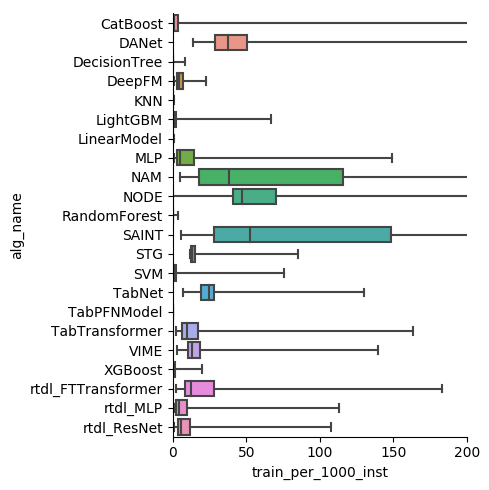

In [40]:
import seaborn as sns

g = sns.catplot(data=pareto_df, y="alg_name", x="train_per_1000_inst", kind="box", whis=(0, 100))
g.set(xlim=(0, 200))
plt.tight_layout()

# Get tuned algorithms for a given metric

Report the average & median test performance, over all folds. Note that each alg is tuned for each fold separately.

In [92]:
tuned_result_dfs = {}
metric = "Accuracy"
time_col = "time__train"
# for drop_default in [True, False]:
drop_default = True

test_metric_col = metric + "__test"
time_per_inst_col = "train_per_1000_inst"

metadataset_df.loc[:, time_per_inst_col] = 1000. * metadataset_df[time_col] / metadataset_df["num_inst"]

if drop_default:
    df = metadataset_df.loc[~metadataset_df["alg_name"].str.contains("_default"), :].copy()
else:
    df = metadataset_df.copy()

tuned_alg_perf = get_tuned_alg_perf(df, metric=metric)

# add column for "time per "


##############################
### STEP 1: TREAT EACH FOLD AS SEPARATE DATASET

result_col = test_metric_col

# for each dataset, find the min and max metrics over all tuned algs
overall_bounds = tuned_alg_perf.groupby("dataset_fold_id").agg({result_col: ["min", "max"]}).reset_index()
overall_time_bounds = tuned_alg_perf.groupby("dataset_fold_id").agg({time_col: ["min", "max"]}).reset_index()

# rename the multiindex cols
new_cols = []
for c in overall_bounds.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))
overall_bounds.columns = new_cols

# rename the multiindex cols
new_cols = []
for c in overall_time_bounds.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))
overall_time_bounds.columns = new_cols

tuned_alg_perf = tuned_alg_perf.merge(overall_bounds, on="dataset_fold_id", how="left")
tuned_alg_perf = tuned_alg_perf.merge(overall_time_bounds, on="dataset_fold_id", how="left")

# add normalized metric
tuned_alg_perf.loc[:, "normalized_" + result_col] = (tuned_alg_perf[result_col] - tuned_alg_perf[result_col + "_min"]) / (tuned_alg_perf[result_col + "_max"] - tuned_alg_perf[result_col + "_min"])
tuned_alg_perf.loc[:, "normalized_" + time_col] = (tuned_alg_perf[time_col] - tuned_alg_perf[time_col + "_min"]) / (tuned_alg_perf[time_col + "_max"] - tuned_alg_perf[time_col + "_min"])

# rank all algs for each dataset
ascending = False # if objective_type == "maximize" else True

tuned_alg_perf.loc[:, f"{metric}_rank"] = tuned_alg_perf.groupby(["dataset_fold_id"])[result_col].rank(method="min", ascending=ascending).values
tuned_alg_perf.loc[:, f"{time_col}_rank"] = tuned_alg_perf.groupby(["dataset_fold_id"])[time_col].rank(method="min", ascending=True).values

# keep these cols to merge
merge_cols = [
    "alg_name", 
    "dataset_fold_id", 
    "normalized_" + result_col,
    "normalized_" + time_col,
    f"{metric}_rank",
    f"{time_col}_rank",
    result_col + "_min",
    result_col + "_max",
    time_col + "_min",
    time_col + "_max"
]

fold_tuned_df = tuned_alg_perf.copy()

##############################
### STEP 2: AVERAGE OVER FOLDS

agg_dict = {
    test_metric_col: ["median", "mean"],
    time_col: ["median", "mean"],
    time_per_inst_col: ["median", "mean"],
}

# aggregate over folds: take the mean & median performance over each fold
agg_tuned_alg_perf = tuned_alg_perf.groupby(["alg_name", "dataset_name"]).agg(agg_dict).reset_index()

# rename the multiindex cols
new_cols = []
for c in agg_tuned_alg_perf.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))

agg_tuned_alg_perf.columns = new_cols


# define the target metric column, we will use this value for all plots
result_col = test_metric_col + "_mean"
time_result_col = time_col + "_mean"

# for each dataset, find the min and max metrics over all tuned algs
overall_bounds = agg_tuned_alg_perf.groupby("dataset_name").agg({result_col: ["min", "max"]}).reset_index()
overall_time_bounds = agg_tuned_alg_perf.groupby("dataset_name").agg({time_result_col: ["min", "max"]}).reset_index()

# tree_runtime = agg_tuned_alg_perf[agg_tuned_alg_perf["alg_name"] == "DecisionTree", time_result_col]

# calcualte avg. runtime per 1000 instances (s)

# adjust the lower bound to be the metric for a tuned decision tree (this is the "baseline")
# baseline_metric = agg_tuned_alg_perf.loc[agg_tuned_alg_perf["alg_name"] == "DecisionTree"].groupby("dataset_name").agg({result_col: "max"}).reset_index()

# baseline_metric.columns = ["dataset_name", "baseline_metric"]

# rename the multiindex cols
new_cols = []
for c in overall_bounds.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))
overall_bounds.columns = new_cols

new_cols = []
for c in overall_time_bounds.columns:
    if c[1] == "":
        new_cols.append(c[0])
    else:
        new_cols.append("_".join(c))
overall_time_bounds.columns = new_cols

agg_tuned_alg_perf = agg_tuned_alg_perf.merge(overall_bounds, on="dataset_name", how="left")
agg_tuned_alg_perf = agg_tuned_alg_perf.merge(overall_time_bounds, on="dataset_name", how="left")

# add normalized metric
agg_tuned_alg_perf.loc[:, "normalized_" + result_col] = (agg_tuned_alg_perf[result_col] - agg_tuned_alg_perf[result_col + "_min"]) / (agg_tuned_alg_perf[result_col + "_max"] - agg_tuned_alg_perf[result_col + "_min"])
agg_tuned_alg_perf.loc[:, "normalized_" + time_col] = (agg_tuned_alg_perf[time_result_col] - agg_tuned_alg_perf[time_result_col + "_min"]) / (agg_tuned_alg_perf[time_result_col + "_max"] - agg_tuned_alg_perf[time_result_col + "_min"])

# rank all algs for each dataset
ascending = False  #  if objective_type == "maximize" else True

# rank according to mean performance over all folds
# do this both with tabpfn (only for the datasets with tabpfn) and without
agg_method = "mean"

# 1) with tabpfn. keep only datasets where tabpfn has a result
tabpfn_datasets = agg_tuned_alg_perf[agg_tuned_alg_perf["alg_name"] == "TabPFNModel"]["dataset_name"].unique()
tabpfn_df = agg_tuned_alg_perf.loc[agg_tuned_alg_perf["dataset_name"].isin(tabpfn_datasets), :]

tabpfn_df.loc[:, f"{metric}_rank_{agg_method}"]  = \
    tabpfn_df.groupby(["dataset_name"])[test_metric_col + "_" + agg_method].rank(method="min", ascending=ascending).values

tabpfn_df.loc[:, f"{time_col}_rank_{agg_method}"]  = \
    tabpfn_df.groupby(["dataset_name"])[time_col + "_" + agg_method].rank(method="min", ascending=True).values
    
tabpfn_df.loc[:, f"{time_per_inst_col}_rank_{agg_method}"]  = \
    tabpfn_df.groupby(["dataset_name"])[time_per_inst_col + "_" + agg_method].rank(method="min", ascending=True).values
    
# 1) without tabpfn. remove all tabpfn results
non_tabpfn_df = agg_tuned_alg_perf.loc[agg_tuned_alg_perf["alg_name"] != "TabPFNModel", :]

non_tabpfn_df.loc[:, f"{metric}_rank_{agg_method}"]  = \
    non_tabpfn_df.groupby(["dataset_name"])[test_metric_col + "_" + agg_method].rank(method="min", ascending=ascending).values

non_tabpfn_df.loc[:, f"{time_col}_rank_{agg_method}"]  = \
    non_tabpfn_df.groupby(["dataset_name"])[time_col + "_" + agg_method].rank(method="min", ascending=True).values

non_tabpfn_df.loc[:, f"{time_per_inst_col}_rank_{agg_method}"]  = \
    non_tabpfn_df.groupby(["dataset_name"])[time_per_inst_col + "_" + agg_method].rank(method="min", ascending=True).values
    

# keep these cols to merge
merge_cols = [
    "alg_name", 
    "dataset_name",
    "normalized_" + result_col,
    "normalized_" + time_col,
    f"{metric}_rank_mean",
    f"{time_col}_rank_mean",
    f"time_per_1000_rank_mean",
    result_col + "_min",
    result_col + "_max",
    time_col + "_min",
    time_col + "_max"
]

tabpfn_tuned_agg_df = tabpfn_df.copy()
non_tabpfn_tuned_agg_df = non_tabpfn_df.copy()

# save results

# if drop_default:
#     tabpfn_agg_df_no_default = tabpfn_tuned_agg_df.copy()
#     non_tabpfn_agg_df_no_default = non_tabpfn_tuned_agg_df.copy()
#     tabpfn_agg_df_no_default.to_csv("./results/tuned_aggregated_results_tabpfn.csv")
#     non_tabpfn_agg_df_no_default.to_csv("./results/tuned_aggregated_results_non_tabpfn.csv")

#     tuned_fold_df_no_default = fold_tuned_df.copy()
#     tuned_fold_df_no_default.to_csv("./results/tuned_fold_results.csv")
    
# else:
#     tabpfn_agg_df_with_default = tabpfn_tuned_agg_df.copy()
#     non_tabpfn_agg_df_with_default = non_tabpfn_tuned_agg_df.copy()
#     tabpfn_agg_df_with_default.to_csv("./results/tuned_aggregated_results_tabpfn_with_default.csv")
#     non_tabpfn_agg_df_with_default.to_csv("./results/tuned_aggregated_results_non_tabpfn_with_default.csv")

#     tuned_fold_df_with_default = fold_tuned_df.copy()
#     tuned_fold_df_with_default.to_csv("./results/tuned_fold_results_with_default_hparams.csv")


In [94]:
tabpfn_tuned_agg_df[tabpfn_tuned_agg_df["dataset_name"] == "openml__Australian__146818"]

,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,train_per_1000_inst_median,train_per_1000_inst_mean,Accuracy__test_mean_min,Accuracy__test_mean_max,time__train_mean_min,time__train_mean_max,normalized_Accuracy__test_mean,normalized_time__train,Accuracy_rank_mean,time__train_rank_mean,train_per_1000_inst_rank_mean
2,CatBoost,openml__Australian__146818,0.869565,0.872464,1.347650,1.393643,2.441396,2.524716,0.711594,0.872464,0.00067,115.468695,1.000000,0.012064,1.0,8.0,8.0
164,DANet,openml__Australian__146818,0.869565,0.862319,42.603970,45.428596,77.181104,82.298181,0.711594,0.872464,0.00067,115.468695,0.936937,0.393424,3.0,19.0,19.0
312,DecisionTree,openml__Australian__146818,0.826087,0.836232,0.003469,0.004876,0.006284,0.008833,0.711594,0.872464,0.00067,115.468695,0.774775,0.000036,13.0,3.0,3.0
483,DeepFM,openml__Australian__146818,0.833333,0.831884,2.730227,2.901542,4.946063,5.256417,0.711594,0.872464,0.00067,115.468695,0.747748,0.025123,15.0,10.0,10.0
573,KNN,openml__Australian__146818,0.702899,0.711594,0.001680,0.001806,0.003044,0.003272,0.711594,0.872464,0.00067,115.468695,0.000000,0.000010,21.0,2.0,2.0
737,LightGBM,openml__Australian__146818,0.855072,0.852174,0.117539,0.150996,0.212933,0.273543,0.711594,0.872464,0.00067,115.468695,0.873874,0.001302,9.0,7.0,7.0
901,LinearModel,openml__Australian__146818,0.855072,0.850725,0.026790,0.029048,0.048533,0.052623,0.711594,0.872464,0.00067,115.468695,0.864865,0.000246,10.0,4.0,4.0
1068,MLP,openml__Australian__146818,0.775362,0.766667,9.116657,7.782056,16.515683,14.097927,0.711594,0.872464,0.00067,115.468695,0.342342,0.067390,17.0,14.0,14.0
1237,NAM,openml__Australian__146818,0.826087,0.839130,57.664400,78.163904,104.464493,141.601275,0.711594,0.872464,0.00067,115.468695,0.792793,0.676925,12.0,20.0,20.0
1316,NODE,openml__Australian__146818,0.855072,0.857971,121.948748,115.468695,220.921644,209.182418,0.711594,0.872464,0.00067,115.468695,0.909910,1.000000,6.0,21.0,21.0


# Aggregate results

In [95]:
non_tabpfn_tuned_agg_df.head(5)

,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,train_per_1000_inst_median,train_per_1000_inst_mean,Accuracy__test_mean_min,Accuracy__test_mean_max,time__train_mean_min,time__train_mean_max,normalized_Accuracy__test_mean,normalized_time__train,Accuracy_rank_mean,time__train_rank_mean,train_per_1000_inst_rank_mean
0,CatBoost,openml__APSFailure__168868,0.994145,0.994013,6.412328,7.276401,0.105466,0.119678,0.970303,0.994500,0.948340,733.621536,0.979880,0.008637,3.0,4.0,4.0
1,CatBoost,openml__Amazon_employee_access__34539,0.946903,0.947359,1.708439,1.729567,0.065169,0.065976,0.930422,0.951570,0.135941,607.382934,0.800861,0.002624,4.0,5.0,5.0
2,CatBoost,openml__Australian__146818,0.869565,0.872464,1.347650,1.393643,2.441396,2.524716,0.711594,0.872464,0.000670,115.468695,1.000000,0.012064,1.0,7.0,7.0
3,CatBoost,openml__Bioresponse__9910,0.798940,0.795521,5.815126,6.748842,1.937729,2.248931,0.736600,0.796848,0.247040,380.891541,0.977987,0.017081,2.0,9.0,9.0
4,CatBoost,openml__Census-Income__168340,0.958869,0.958658,830.825629,857.921920,3.470058,3.583213,0.945370,0.958658,0.643396,857.921920,1.000000,1.000000,1.0,12.0,12.0


In [96]:
###### NO default hparams, and NO tabpfn

# remove tabpfn due to dataset restrictions - this method has its own table

# best, worst, and average performance for each alg, over all datasets

# metric = time_col
metric = time_per_inst_col

# overall_ranks = non_tabpfn_agg_df_no_default.groupby("alg_name").agg(
overall_ranks = non_tabpfn_tuned_agg_df.groupby("alg_name").agg(
    {
        f"{metric}_rank_mean": ["min", "max", "mean", "count"],
        f"{metric}_mean": "mean",
    }
).reset_index().sort_values([(f"{metric}_rank_mean", "mean")])

# format min/max rank columns to be ints

overall_ranks.loc[:, "count"] = overall_ranks.loc[:, (f"{metric}_rank_mean", "count")].astype(int)
overall_ranks.drop(columns=(f"{metric}_rank_mean", "count"), inplace=True)

# overall_ranks.loc[:, "alg_name"] = overall_ranks.loc[:, "alg_name"].apply(lambda x: "\rot{" + x + "}")
overall_ranks.loc[:, (f"{metric}_rank_mean", "min")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "min")].astype(int)
overall_ranks.loc[:, (f"{metric}_rank_mean", "max")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "max")].astype(int)

overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")].round(2)

# overall_ranks.loc[:, (f"normalized_{metric}", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}", "mean")].round(2)
overall_ranks.loc[:, (f"{metric}_mean", "mean")] = overall_ranks.loc[:,(f"{metric}_mean", "mean")].round(2)

print(f"metric: train-time")
final_table = overall_ranks.set_index("alg_name")
print(final_table)

# save to csv
final_table.to_csv(f"./results/time_rank_tables.csv", index=True)

# save to latex
final_table.to_latex(f"./results/time_rank_tables.tex", index=True, escape=False)


print("\n")

metric: train-time
                   train_per_1000_inst_rank_mean             \
                                             min max   mean   
alg_name                                                      
KNN                                            1   4   1.41   
LinearModel                                    1   5   2.41   
DecisionTree                                   1   8   2.51   
RandomForest                                   1   7   4.76   
XGBoost                                        1  15   5.67   
LightGBM                                       4  15   6.30   
CatBoost                                       3  19   7.79   
rtdl_MLP                                       2  15   9.19   
SVM                                            3  20   9.23   
DeepFM                                         6  15   9.30   
MLP                                            3  17  10.38   
rtdl_ResNet                                    4  16  10.44   
TabTransformer                      

In [ ]:
###### NO default hparams, and NO tabpfn
### --- now rank by training time

# remove tabpfn due to dataset restrictions - this method has its own table

# best, worst, and average performance for each alg, over all datasets

overall_ranks = non_tabpfn_agg_df_no_default.groupby("alg_name").agg(
    {
        f"time__train_mean": ["min", "max", "mean", "count"],
        f"normalized_time__train_mean": "mean",
    }
).reset_index().sort_values([(f"{metric}_rank_mean", "mean")])

# format min/max rank columns to be ints

overall_ranks.loc[:, "count"] = overall_ranks.loc[:, (f"{metric}_rank_mean", "count")].astype(int)
overall_ranks.drop(columns=(f"{metric}_rank_mean", "count"), inplace=True)

# overall_ranks.loc[:, "alg_name"] = overall_ranks.loc[:, "alg_name"].apply(lambda x: "\rot{" + x + "}")
overall_ranks.loc[:, (f"{metric}_rank_mean", "min")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "min")].astype(int)
overall_ranks.loc[:, (f"{metric}_rank_mean", "max")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "max")].astype(int)

overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")].round(2)

overall_ranks.loc[:, (f"normalized_{metric}__test_mean", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}__test_mean", "mean")].round(2)

print(f"metric: {metric}")
final_table = overall_ranks.set_index("alg_name")
print(final_table)

# save to csv
final_table.to_csv(f"./results/rank_tables_traintime.csv", index=True)

# save to latex
final_table.to_latex(f"./results/rank_tables_traintime.tex", index=True, escape=False)


    print("\n")

In [49]:
###### NO default, WITH tabpfn

# best, worst, and average performance for each alg, over all datasets
for metric in metric_list:

    overall_ranks = tabpfn_agg_df_no_default.groupby("alg_name").agg(
        {
            f"{metric}_rank_mean": ["min", "max", "mean", "count"],
            f"normalized_{metric}__test_mean": "mean",
        }
    ).reset_index().sort_values([(f"{metric}_rank_mean", "mean")])

    # format min/max rank columns to be ints

    overall_ranks.loc[:, "count"] = overall_ranks.loc[:, (f"{metric}_rank_mean", "count")].astype(int)
    overall_ranks.drop(columns=(f"{metric}_rank_mean", "count"), inplace=True)

    # overall_ranks.loc[:, "alg_name"] = overall_ranks.loc[:, "alg_name"].apply(lambda x: "\rot{" + x + "}")
    overall_ranks.loc[:, (f"{metric}_rank_mean", "min")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "min")].astype(int)
    overall_ranks.loc[:, (f"{metric}_rank_mean", "max")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "max")].astype(int)

    overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")].round(2)
    
    overall_ranks.loc[:, (f"normalized_{metric}__test_mean", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}__test_mean", "mean")].round(2)

    print(f"metric: {metric}")
    final_table = overall_ranks.set_index("alg_name")
    print(final_table)

    # save to csv
    final_table.to_csv(f"./results/rank_tables_{metric}-tabpfn.csv", index=True)

    # save to latex
    final_table.to_latex(f"./results/rank_tables_{metric}-tabpfn.tex", index=True, escape=False)


    print("\n")

metric: Accuracy
                   Accuracy_rank_mean             \
                                  min max   mean   
alg_name                                           
TabPFNModel                         1  20   4.92   
CatBoost                            1  19   5.68   
rtdl_ResNet                         1  21   7.48   
SAINT                               1  20   7.81   
rtdl_FTTransformer                  1  18   8.32   
RandomForest                        1  19   8.37   
NODE                                1  21   8.48   
XGBoost                             1  20   8.86   
DeepFM                              1  22   9.43   
rtdl_MLP                            1  19  10.10   
SVM                                 1  20  10.24   
LinearModel                         1  21  10.65   
LightGBM                            1  21  10.89   
DANet                               1  21  11.40   
MLP                                 1  20  12.19   
TabTransformer                      1  22  12.3

## UNDER CONSTRUCTION: spaghetti plot - relative performance over different datasets.

In [59]:
tabpfn_agg_df_no_default[tabpfn_agg_df_no_default["alg_name"] == "TabPFNModel"])

,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,Accuracy__test_mean_min,Accuracy__test_mean_max,normalized_Accuracy__test_mean,Accuracy_rank_mean,normalized_F1__test_mean,F1_rank_mean,F1__test_mean_min,F1__test_mean_max,normalized_Log Loss__test_mean,Log Loss_rank_mean,Log Loss__test_mean_min,Log Loss__test_mean_max
886,TabPFNModel,openml__Australian__146818,0.855072,0.866667,0.000661,0.000670,0.711594,0.872464,9.639640e-01,2.0,9.639640e-01,2.0,0.711594,0.872464,0.080464,3.0,3.026771e-01,0.755920
887,TabPFNModel,openml__LED-display-domain-7digit__125921,0.680000,0.698000,0.000374,0.000405,0.698000,0.736000,0.000000e+00,19.0,0.000000e+00,19.0,0.690748,0.731609,0.131496,11.0,8.274095e-01,2.539521
888,TabPFNModel,openml__MiceProtein__146800,1.000000,0.998148,0.000434,0.000470,0.661111,0.998148,1.000000e+00,1.0,1.000000e+00,1.0,0.614618,0.998148,0.012288,3.0,1.198685e-02,1.380437
889,TabPFNModel,openml__acute-inflammations__10089,1.000000,1.000000,0.000584,0.000539,0.600000,1.000000,1.000000e+00,1.0,1.000000e+00,1.0,0.600000,1.000000,0.000312,6.0,9.992007e-16,1.774646
890,TabPFNModel,openml__analcatdata_authorship__3549,1.000000,0.998824,0.000381,0.000415,0.936989,0.998824,1.000000e+00,1.0,1.000000e+00,1.0,0.933857,0.998823,0.002487,2.0,7.473539e-03,0.909328
891,TabPFNModel,openml__analcatdata_boxing1__3540,0.666667,0.675000,0.000364,0.000402,0.575000,0.841667,3.750000e-01,10.0,3.750000e-01,10.0,0.575000,0.841667,0.069648,9.0,4.475764e-01,3.317489
892,TabPFNModel,openml__analcatdata_chlamydia__3739,0.900000,0.890000,0.000387,0.000425,0.740000,0.940000,7.500000e-01,7.0,7.500000e-01,7.0,0.740000,0.940000,0.003608,3.0,1.642215e-01,8.304631
893,TabPFNModel,openml__analcatdata_dmft__3560,0.207595,0.207009,0.000501,0.000529,0.171915,0.243354,4.912514e-01,13.0,0.000000e+00,19.0,0.134696,0.224598,0.022922,4.0,1.759146e+00,2.084400
894,TabPFNModel,openml__anneal__2867,0.983333,0.977690,0.001344,0.001563,0.761698,0.992210,9.370126e-01,8.0,9.615027e-01,7.0,0.658539,0.990714,0.004914,4.0,3.166911e-02,8.094104
895,TabPFNModel,openml__autos__9,0.780952,0.766190,0.000537,0.000553,0.271667,0.815238,9.097678e-01,5.0,9.002671e-01,5.0,0.239959,0.799820,0.003839,3.0,6.015017e-01,18.282990


In [18]:
# which datasets to use?

result_df_dict["F1"][(result_df_dict["F1"]["alg_name"] == "CatBoost") & (result_df_dict["F1"]["metric_rank_mean"] < 2)]

KeyError: 'metric_rank_mean'

In [23]:
# openml__diabetes__37 <-- lm does well
# openml__isolet__3481
# openml__haberman__42
# openml__robert__168332

# openml__soybean__41 <-- rf does well
# openml__vowel__3022
# openml__guillermo__168337

# openml__cmc__23 <-- mlp does well
# openml__CIFAR_10__167124
# openml__Fashion-MNIST__146825
# openml__Internet-Advertisements__167125	
# openml__dilbert__168909

# openml__Australian__146818 <-- catboost
# openml__APSFailure__168868
# openml__wdbc__9946
# openml__pc1__3918
# openml__eucalyptus__2079

In [24]:
plot_datasets = [
    "openml__diabetes__37",  # <-- lm does well
    "openml__isolet__3481",
    "openml__haberman__42",
    # "openml__robert__168332", # not enough successful algs
    "openml__soybean__41", #  <-- rf does well
    "openml__vowel__3022",
    # "openml__guillermo__168337", # not enough successful algs
    "openml__cmc__23", # <-- mlp does well
    # "openml__CIFAR_10__167124",  # not enough successful algs
    # "openml__Fashion-MNIST__146825",  # not enough successful algs
    "openml__Internet-Advertisements__167125",	
    "openml__dilbert__168909",
    "openml__Australian__146818",  #<-- catboost
    "openml__APSFailure__168868",
    "openml__wdbc__9946",
    "openml__pc1__3918",
    "openml__eucalyptus__2079",
]

# names to show on the plot
plot_dataset_names = [name[len("openml__"):].split("_")[0] for name in plot_datasets]

In [25]:
# number of results for each dataset
num_alg_per_dataset = result_df_dict["F1"].groupby("dataset_name")["alg_name"].count()
num_alg_per_dataset[num_alg_per_dataset < 10].sort_values()

dataset_name
openml__Devnagari-Script__167121                          5
openml__covertype__7593                                   5
openml__helena__168329                                    5
openml__CIFAR_10__167124                                  6
openml__albert__189356                                    6
openml__guillermo__168337                                 6
openml__Fashion-MNIST__146825                             7
openml__riccardo__168338                                  7
openml__robert__168332                                    7
openml__airlines__189354                                  8
openml__mnist_784__3573                                   8
openml__higgs__146606                                     9
openml__jungle_chess_2pcs_raw_endgame_complete__167119    9
openml__numerai28.6__167120                               9
openml__skin-segmentation__9965                           9
openml__sylvine__168912                                   9
Name: alg_name, dtype: int6

In [26]:
plot_algs = agg_tuned_alg_perf["alg_name"].unique()

# gather data for the spaghetti plot
data = dict()
for i_metric, metric_name in enumerate(metric_list):
    data[metric_name] = dict()
    for alg in plot_algs:
            data[metric_name][alg] = []
            for dataset in plot_datasets:
                vals = result_df_dict[metric_name].loc[(result_df_dict[metric_name]["alg_name"] == alg) & (result_df_dict[metric_name]["dataset_name"] == dataset), f"normalized_{metric_name}__test_mean"].values
                if len(vals) != 1:
                    print(f"there's an issue with {alg}-{dataset}-{metric_name}")
                    print(vals)
                    val = None
                else:
                    val = vals[0]
                data[metric_name][alg].append(val)
        

there's an issue with CatBoost-openml__isolet__3481-Accuracy
[]
there's an issue with LightGBM-openml__dilbert__168909-Accuracy
[]
there's an issue with RandomForest-openml__haberman__42-Accuracy
[]
there's an issue with SVM-openml__soybean__41-Accuracy
[]
there's an issue with CatBoost-openml__isolet__3481-F1
[]
there's an issue with LightGBM-openml__dilbert__168909-F1
[]
there's an issue with RandomForest-openml__haberman__42-F1
[]
there's an issue with SVM-openml__soybean__41-F1
[]
there's an issue with CatBoost-openml__isolet__3481-Log Loss
[]
there's an issue with LightGBM-openml__dilbert__168909-Log Loss
[]
there's an issue with RandomForest-openml__haberman__42-Log Loss
[]
there's an issue with SVM-openml__soybean__41-Log Loss
[]


In [1]:
### plotting kwargs

plot_alg_map = {
    "XGBoost": {
        "name": "XGBoost",
        "plt-kwargs": {"marker":"x", "color":"r", "linestyle":"--"}
    },
    "CatBoost": {
        "name": "CatBoost",
        "plt-kwargs": {"marker":"+", "color":"r", "linestyle":"--"}
    },
    "LightGBM": {
        "name": "LightGBM",
        "plt-kwargs": {"marker":"d", "color":"r", "linestyle":"--"}
    },
    "SVM": {
        "name": "SVM",
        "plt-kwargs": {"marker":"v", "color":"black", "linestyle":"-"}
    },
    "KNN": {
        "name": "KNN",
        "plt-kwargs": {"marker":"^", "color":"black", "linestyle":"-"}
    },
    "DecisionTree": {
        "name": "DecisionTree",
        "plt-kwargs": {"marker":">", "color":"black", "linestyle":"-"}
    },
    "RandomForest": {
        "name": "RandomForest",
        "plt-kwargs": {"marker":"P", "color":"black", "linestyle":"-"}
    },
    "LinearModel": {
        "name": "LinearModel",
        "plt-kwargs": {"marker":"<", "color":"black", "linestyle":"-"}
    },
    "TabNet": {
        "name": "TabNet",
        "plt-kwargs": {"marker":"X", "color":"b", "linestyle":":"}
    },
    "MLP": {
        "name": "MLP",
        "plt-kwargs": {"marker":"o", "color":"b", "linestyle":":"}
    },
    "VIME": {
        "name": "VIME",
        "plt-kwargs": {"marker":"P", "color":"b", "linestyle":":"}
    },
}

plot_algs = plot_alg_map.keys()

In [2]:
import numpy as np
fig, ax = plt.subplots(len(metric_list), 1, sharex=True, figsize=(8, 5))

for i, metric in enumerate(metric_list):
    for alg in plot_algs:    
        ax[i].plot(data[metric][alg], label=alg, markersize=7, **plot_alg_map[alg]["plt-kwargs"])
    ax[i].set_ylabel(metric)

    ax[i].set_xticks(np.arange(len(plot_dataset_names)))
    ax[i].set_xticklabels(plot_dataset_names, rotation=-35, ha='left', rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(hspace=0.08)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 3.6), ncol=6, fontsize="small")
plt.savefig("./results/performance_spaghetti.pdf", bbox_inches='tight')
plt.show()


NameError: name 'plt' is not defined